In [1]:
import numpy as np
import pandas as pd 
import sklearn
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout
import matplotlib.pyplot as plt
%matplotlib inline
import os
import cv2
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from matplotlib import style
import glob
np.random.seed(42)

## Taxi fare prediction using neural network

In [2]:
link_train = "https://raw.githubusercontent.com/gagan-iitb/CS550/main/Prog_Assignments/train_NYTaxi.csv"
link_test  = "https://raw.githubusercontent.com/gagan-iitb/CS550/main/Prog_Assignments/test_NYTaxi.csv"
train = pd.read_csv(link_train)
test  = pd.read_csv(link_test)

In [3]:
## Checking the no. of rows and columns in train and test set
print("Shape of train set : ",train.shape)
print("Shape of test set : ",test.shape)
print(list(train.columns))
print(list(test.columns))

Shape of train set :  (100000, 9)
Shape of test set :  (9914, 7)
['Unnamed: 0', 'key', 'fare_amount', 'pickup_datetime', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'passenger_count']
['key', 'pickup_datetime', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'passenger_count']


In [4]:
train.head()

,Unnamed: 0,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,0,2009-04-08 19:11:10.0000004,4.9,2009-04-08 19:11:10 UTC,-73.998287,40.727490,-73.989854,40.735239,2
1,1,2012-07-30 16:19:08.0000003,4.9,2012-07-30 16:19:08 UTC,-73.966597,40.794345,-73.965682,40.803808,2
2,2,2011-02-22 13:35:00.000000121,6.9,2011-02-22 13:35:00 UTC,-73.971638,40.763382,-73.953767,40.783715,1
3,3,2010-10-07 21:09:35.0000002,14.1,2010-10-07 21:09:35 UTC,-74.003545,40.707399,-73.981312,40.750071,1
4,4,2009-10-02 22:51:00.000000140,12.1,2009-10-02 22:51:00 UTC,-74.004532,40.707465,-73.977908,40.745633,5


In [5]:
## dropping the "Unnamed: 0" column
train = train.drop("Unnamed: 0",axis=1)

In [6]:
train.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-04-08 19:11:10.0000004,4.9,2009-04-08 19:11:10 UTC,-73.998287,40.727490,-73.989854,40.735239,2
1,2012-07-30 16:19:08.0000003,4.9,2012-07-30 16:19:08 UTC,-73.966597,40.794345,-73.965682,40.803808,2
2,2011-02-22 13:35:00.000000121,6.9,2011-02-22 13:35:00 UTC,-73.971638,40.763382,-73.953767,40.783715,1
3,2010-10-07 21:09:35.0000002,14.1,2010-10-07 21:09:35 UTC,-74.003545,40.707399,-73.981312,40.750071,1
4,2009-10-02 22:51:00.000000140,12.1,2009-10-02 22:51:00 UTC,-74.004532,40.707465,-73.977908,40.745633,5


In [7]:
test.head()

,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2015-01-27 13:08:24.0000002,2015-01-27 13:08:24 UTC,-73.973320,40.763805,-73.981430,40.743835,1
1,2015-01-27 13:08:24.0000003,2015-01-27 13:08:24 UTC,-73.986862,40.719383,-73.998886,40.739201,1
2,2011-10-08 11:53:44.0000002,2011-10-08 11:53:44 UTC,-73.982524,40.751260,-73.979654,40.746139,1
3,2012-12-01 21:12:12.0000002,2012-12-01 21:12:12 UTC,-73.981160,40.767807,-73.990448,40.751635,1
4,2012-12-01 21:12:12.0000003,2012-12-01 21:12:12 UTC,-73.966046,40.789775,-73.988565,40.744427,1


**Data Cleaning**

**Checking for null values:**

In [8]:
train.isnull().sum()

key                  0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
dtype: int64

In [9]:
test.isnull().sum()

key                  0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
dtype: int64

As we can see there are 0 null values for all the features in train data set so we will go further and check for negative fare_amount values

In [10]:
### droping duplicates
train.drop_duplicates(inplace=True)

In [11]:
train.shape

(100000, 8)

**Checking for negative fare amount:**

In [12]:
train['fare_amount'].describe()

count    100000.000000
mean         11.333564
std           9.810826
min          -9.300000
25%           6.000000
50%           8.500000
75%          12.500000
max         394.000000
Name: fare_amount, dtype: float64

We are getting **minimum fare_amount value as negative**  which is not possible , so we will drop the rows having negative fare amount.

In [13]:
## filtering the rows having non positive fare amount
train=train.loc[train["fare_amount"]>0]
## Checking for minimum fare_amount value again
train["fare_amount"].describe()

count    99994.000000
mean        11.334431
std          9.810440
min          0.010000
25%          6.000000
50%          8.500000
75%         12.500000
max        394.000000
Name: fare_amount, dtype: float64

**Checking the passenger count:**

In [14]:
train["passenger_count"].describe()

count    99994.000000
mean         1.682151
std          1.308636
min          0.000000
25%          1.000000
50%          1.000000
75%          2.000000
max          6.000000
Name: passenger_count, dtype: float64

In [15]:
test['passenger_count'].describe()

count    9914.000000
mean        1.671273
std         1.278747
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max         6.000000
Name: passenger_count, dtype: float64

In [16]:
## dropping the rows having zero passenger count
train=train.loc[train["passenger_count"]>0]

In [17]:
print("Shape of Train: ", train.shape)

Shape of Train:  (99625, 8)


**Now, lets check lattitudes and longitudes**

We know that:

1.   Lattitudes range between -90 to 90
2.   Longitudes range between -180 to 180



In [18]:
train = train.loc[train["pickup_latitude"]<90]
train = train.loc[train["pickup_latitude"]>-90]

train = train.loc[train["dropoff_latitude"]<90]
train = train.loc[train["dropoff_latitude"]>-90]

train = train.loc[train["pickup_longitude"]<180]
train = train.loc[train["pickup_longitude"]>-180]

train = train.loc[train["dropoff_longitude"]<180]
train = train.loc[train["dropoff_longitude"]>-180]

In [19]:
print("Shape of Train: ", train.shape)

Shape of Train:  (99622, 8)


In [20]:
test = test.loc[test["pickup_latitude"]<90]
test = test.loc[test["pickup_latitude"]>-90]

test = test.loc[test["dropoff_latitude"]<90]
test = test.loc[test["dropoff_latitude"]>-90]

test = test.loc[test["pickup_longitude"]<180]
test = test.loc[test["pickup_longitude"]>-180]

test = test.loc[test["dropoff_longitude"]<180]
test = test.loc[test["dropoff_longitude"]>-180]

In [21]:
print("Shape of Test: ", test.shape)

Shape of Test:  (9914, 7)


In [22]:
train.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,99622.000000,99622.000000,99622.000000,99622.000000,99622.000000,99622.000000
mean,11.342516,-72.440074,39.882427,-72.455499,39.889650,1.688352
std,9.821215,10.672429,6.284058,10.620103,6.263451,1.306984
min,0.010000,-121.391202,-74.015935,-121.391318,-74.011085,1.000000
25%,6.000000,-73.992133,40.734777,-73.991443,40.734021,1.000000
50%,8.500000,-73.981851,40.752457,-73.980215,40.753081,1.000000
75%,12.500000,-73.967171,40.767024,-73.963724,40.768036,2.000000
max,394.000000,40.801777,42.603366,40.787037,44.640672,6.000000


In [23]:
test.describe()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000
mean,-73.974722,40.751041,-73.973657,40.751743,1.671273
std,0.042774,0.033541,0.039072,0.035435,1.278747
min,-74.252193,40.573143,-74.263242,40.568973,1.000000
25%,-73.992501,40.736125,-73.991247,40.735254,1.000000
50%,-73.982326,40.753051,-73.980015,40.754065,1.000000
75%,-73.968013,40.767113,-73.964059,40.768757,2.000000
max,-72.986532,41.709555,-72.990963,41.696683,6.000000


/usr/local/lib/python3.9/dist-packages/pandas/plotting/_matplotlib/core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


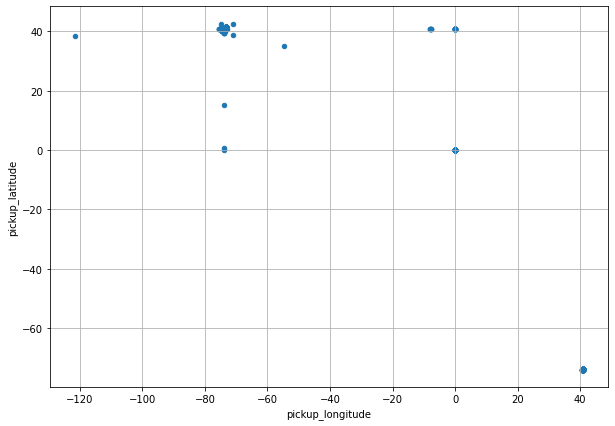

In [24]:
train.plot(kind="scatter",x="pickup_longitude",y="pickup_latitude",figsize=(10,7))
plt.grid()
plt.show()

From the above scatter plot we can see that the range of latitude and longitude is quite large (beyond the range of new york city) New York Latitude and Longitude coordinates are :(40.7128° N , 74.0060° W ) 

So we will filter this latitudes(in range of 40.5 to 41.8) and longitudes(in range of -74.5 to -72.8) as we are building the model only for city.

In [25]:
latitude_max = 41.8
latitude_min = 40.5
longitude_max = -72.8
longitude_min = -74.5

train = train.loc[train["pickup_latitude"]<latitude_max]
train = train.loc[train["pickup_latitude"]>latitude_min]

train = train.loc[train["dropoff_latitude"]<latitude_max]
train = train.loc[train["dropoff_latitude"]>latitude_min]

train = train.loc[train["pickup_longitude"]<longitude_max]
train = train.loc[train["pickup_longitude"]>longitude_min]

train = train.loc[train["dropoff_longitude"]<longitude_max]
train = train.loc[train["dropoff_longitude"]>longitude_min]

In [26]:
print("Shape of Train: ", train.shape)

Shape of Train:  (97454, 8)


In [27]:
test = test.loc[test["pickup_latitude"]<latitude_max]
test = test.loc[test["pickup_latitude"]>latitude_min]

test = test.loc[test["dropoff_latitude"]<latitude_max]
test = test.loc[test["dropoff_latitude"]>latitude_min]

test = test.loc[test["pickup_longitude"]<longitude_max]
test = test.loc[test["pickup_longitude"]>longitude_min]

test = test.loc[test["dropoff_longitude"]<longitude_max]
test = test.loc[test["dropoff_longitude"]>longitude_min]

In [28]:
print("Shape of Test: ", test.shape)

Shape of Test:  (9914, 7)


**Converting Datatypes**

In [29]:
## checking datatypes of various attributes in the train set and test set
train.dtypes, test.dtypes

(key                   object
 fare_amount          float64
 pickup_datetime       object
 pickup_longitude     float64
 pickup_latitude      float64
 dropoff_longitude    float64
 dropoff_latitude     float64
 passenger_count        int64
 dtype: object, key                   object
 pickup_datetime       object
 pickup_longitude     float64
 pickup_latitude      float64
 dropoff_longitude    float64
 dropoff_latitude     float64
 passenger_count        int64
 dtype: object)

Here "**key**" and "**pickup_datetime**" have data type as **object** so we need to convert them into **datetime**

In [30]:
## converting "key" and "pickup_datetime" to date_time
train["key"]=pd.to_datetime(train["key"])
train["pickup_datetime"]=pd.to_datetime(train["pickup_datetime"])
test["key"]=pd.to_datetime(test["key"])
test["pickup_datetime"]=pd.to_datetime(test["pickup_datetime"])

Splitting the datetime field 'pickup_datetime' to the following -

*  hour
*  day of week
*  day of month
*  week
*  month
*  year

In [31]:
data = [train,test]
for i in data:
    i['Year'] = i['pickup_datetime'].dt.year
    i['Month'] = i['pickup_datetime'].dt.month
    i['Date'] = i['pickup_datetime'].dt.day
    i['Day of Week'] = i['pickup_datetime'].dt.dayofweek
    i['Hour'] = i['pickup_datetime'].dt.hour

In [32]:
# Remove the pickup_datetime column since it's no longer needed
train = train.drop(['pickup_datetime'], axis=1)
test = test.drop(['pickup_datetime'], axis=1)


In [33]:
# Also removing the key column
train = train.drop(['key'], axis=1)
test = test.drop(['key'], axis=1)

In [34]:
def haversine_distance(lat1, long1, lat2, long2):
    data = [train, test]
    for i in data:
        R = 6371  #radius of earth in kilometers
        phi1 = np.radians(i[lat1])
        phi2 = np.radians(i[lat2])
    
        delta_phi = np.radians(i[lat2]-i[lat1])
        delta_lambda = np.radians(i[long2]-i[long1])
    
        #a = sin²((φB - φA)/2) + cos φA . cos φB . sin²((λB - λA)/2)
        a = np.sin(delta_phi / 2.0) ** 2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda / 2.0) ** 2
    
        #c = 2 * atan2( √a, √(1−a) )
        c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    
        #d = R*c
        d = (R * c) #in kilometers
        i['H_Distance'] = d
    return d

In [35]:
## calculating the Haversine distance and adding this values in the new feature : "H_distance"
haversine_distance('pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude') ##in kilometers

0        2.323260
1        2.425353
2        0.618628
3        1.961033
4        5.387301
          ...    
9909     2.124874
9910     3.270969
9911    19.183941
9912     8.343486
9913     1.180825
Length: 9914, dtype: float64

In [36]:
train.head()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,Year,Month,Date,Day of Week,Hour,H_Distance
0,4.9,-73.998287,40.727490,-73.989854,40.735239,2,2009,4,8,2,19,1.116850
1,4.9,-73.966597,40.794345,-73.965682,40.803808,2,2012,7,30,0,16,1.055053
2,6.9,-73.971638,40.763382,-73.953767,40.783715,1,2011,2,22,1,13,2.715959
3,14.1,-74.003545,40.707399,-73.981312,40.750071,1,2010,10,7,3,21,5.101370
4,12.1,-74.004532,40.707465,-73.977908,40.745633,5,2009,10,2,4,22,4.800593


In [37]:
test.head()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,Year,Month,Date,Day of Week,Hour,H_Distance
0,-73.973320,40.763805,-73.981430,40.743835,1,2015,1,27,1,13,2.323260
1,-73.986862,40.719383,-73.998886,40.739201,1,2015,1,27,1,13,2.425353
2,-73.982524,40.751260,-73.979654,40.746139,1,2011,10,8,5,11,0.618628
3,-73.981160,40.767807,-73.990448,40.751635,1,2012,12,1,5,21,1.961033
4,-73.966046,40.789775,-73.988565,40.744427,1,2012,12,1,5,21,5.387301


In [38]:
# Dropping irrevelant distance values
train= train.loc[train["H_Distance"]>0]
test= test.loc[test["H_Distance"]>0]

In [39]:
from sklearn.preprocessing import StandardScaler

standard_scaler = StandardScaler()
train_scaled = pd.DataFrame(standard_scaler.fit_transform(train),columns=train.columns)
test_scaled = pd.DataFrame(standard_scaler.fit_transform(test),columns=test.columns)


In [40]:
# create X and y values (features and labels)
X = train_scaled.drop("fare_amount",axis=1)
y = train_scaled['fare_amount']

In [41]:
X.head()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,Year,Month,Date,Day of Week,Hour,H_Distance
0,-0.632151,-0.838975,-0.436248,-0.514699,0.239427,-1.469139,-0.660233,-0.884221,-0.527859,0.842335,-0.590303
1,0.245833,1.554317,0.262125,1.682577,0.239427,0.138243,0.212896,1.647198,-1.553198,0.381766,-0.606527
2,0.106170,0.445896,0.606371,1.038702,-0.526611,-0.397551,-1.242319,0.726682,-1.040529,-0.078803,-0.170488
3,-0.777826,-1.558197,-0.189454,-0.039411,-0.526611,-0.933345,1.086025,-0.999285,-0.015189,1.149381,0.455756
4,-0.805171,-1.555835,-0.091106,-0.181626,2.537540,-1.469139,1.086025,-1.574608,0.497481,1.302904,0.376793


In [42]:
min(train['fare_amount']),max(train['fare_amount'])

(0.01, 394.0)

In [43]:
# creating train and test set
from sklearn.model_selection import train_test_split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
len(X), len(X_train), len(X_test)

(96467, 77173, 19294)

In [44]:
X_train = tf.constant(X_train)
y_train = tf.constant(y_train)
X_test = tf.constant(X_test)
y_test = tf.constant(y_test)

**A.**   Create a baseline Neural network with the following specifications.
2 hidden layers, each with 16 and 8 neurons respectively. Sigmoid activation, Batch Size=128 for
Gradient Descent.

In [45]:
tf.random.set_seed(42)
# Building a model
taxi_fare_model_1 = tf.keras.Sequential([
                                       tf.keras.layers.Dense(16, activation='sigmoid',input_dim=X_train.shape[1]), #16 neurons    -->hidden layer 1
                                       tf.keras.layers.BatchNormalization(),
                                       tf.keras.layers.Dense(8, activation='sigmoid'),  #8  neurons    -->hidden layer 2
                                       tf.keras.layers.BatchNormalization(),
                                       tf.keras.layers.Dense(1)                         # output layer
])

# Compiling the model
taxi_fare_model_1.compile(loss = tf.keras.losses.mae,
                        optimizer = tf.keras.optimizers.SGD(learning_rate=0.0095),
                        metrics = ["mape","mae","mse"]
                        )

# Fitting the model
history = taxi_fare_model_1.fit(X_train, y_train, epochs = 50, batch_size=128)

Epoch 1/50
603/603 [==============================] - 2s 2ms/step - loss: 0.2995 - mape: 207.4386 - mae: 0.2995 - mse: 0.3449
Epoch 2/50
603/603 [==============================] - 1s 2ms/step - loss: 0.2675 - mape: 192.5296 - mae: 0.2675 - mse: 0.2925
Epoch 3/50
603/603 [==============================] - 1s 2ms/step - loss: 0.2577 - mape: 188.2336 - mae: 0.2577 - mse: 0.2780
Epoch 4/50
603/603 [==============================] - 1s 2ms/step - loss: 0.2528 - mape: 185.2188 - mae: 0.2528 - mse: 0.2714
Epoch 5/50
603/603 [==============================] - 1s 2ms/step - loss: 0.2481 - mape: 183.4759 - mae: 0.2481 - mse: 0.2657
Epoch 6/50
603/603 [==============================] - 1s 2ms/step - loss: 0.2452 - mape: 181.4677 - mae: 0.2452 - mse: 0.2607
Epoch 7/50
603/603 [==============================] - 1s 2ms/step - loss: 0.2423 - mape: 180.8167 - mae: 0.2423 - mse: 0.2572
Epoch 8/50
603/603 [==============================] - 1s 2ms/step - loss: 0.2398 - mape: 177.6350 - mae: 0.2398 - mse:

In [46]:
taxi_fare_model_1.evaluate(X_test,y_test)

603/603 [==============================] - 1s 1ms/step - loss: 0.1962 - mape: 138.0390 - mae: 0.1962 - mse: 0.2133


[0.19618810713291168,
 138.03904724121094,
 0.19618810713291168,
 0.21330878138542175]

In [47]:
pred=taxi_fare_model_1.predict(X_test)

603/603 [==============================] - 1s 1ms/step


In [48]:
from sklearn.metrics import mean_squared_error,mean_absolute_percentage_error,mean_absolute_error
print("MAPE : ",mean_absolute_percentage_error(y_test,pred))
print("MAE : ",mean_absolute_error(y_test,pred))
print("MSE : ",mean_squared_error(y_test,pred))


MAPE :  1.3803911014637211
MAE :  0.19618817018041976
MSE :  0.21330872026568173


Text(0.5, 0, 'epochs')

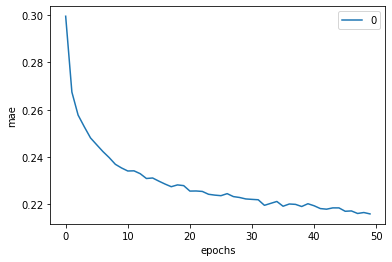

In [49]:
# Plot history (also known as a loss curve or a training curve)
pd.DataFrame(history.history['mae']).plot()
plt.ylabel("mae")
plt.xlabel("epochs")

In [50]:
m1=[mean_absolute_percentage_error(y_test,pred),mean_absolute_error(y_test,pred),mean_squared_error(y_test,pred)]
m1

[1.3803911014637211, 0.19618817018041976, 0.21330872026568173]

 **B. Experiment with number of layers and neurons per layer to increase the
performance metrics.**

In [51]:
## decreasing number of hidden layers:
taxi_fare_model_2_a = tf.keras.Sequential([
                                       tf.keras.layers.Dense(16, activation='sigmoid', input_dim=X_train.shape[1]),
                                       tf.keras.layers.BatchNormalization(),
                                       tf.keras.layers.Dense(1)                             ## final output layer with only 1 neuron
                                    ])


taxi_fare_model_2_a.compile(loss = tf.keras.losses.mae,
                        optimizer = tf.keras.optimizers.SGD(learning_rate=0.0095),
                        metrics = ["mape","mae","mse"]
                        )


history = taxi_fare_model_2_a.fit(X_train, y_train, epochs = 50,batch_size=128)


Epoch 1/50
603/603 [==============================] - 2s 2ms/step - loss: 0.3222 - mape: 219.9948 - mae: 0.3222 - mse: 0.4229
Epoch 2/50
603/603 [==============================] - 1s 2ms/step - loss: 0.2588 - mape: 185.6548 - mae: 0.2588 - mse: 0.2855
Epoch 3/50
603/603 [==============================] - 1s 1ms/step - loss: 0.2504 - mape: 182.4979 - mae: 0.2504 - mse: 0.2726
Epoch 4/50
603/603 [==============================] - 1s 1ms/step - loss: 0.2477 - mape: 180.4915 - mae: 0.2477 - mse: 0.2679
Epoch 5/50
603/603 [==============================] - 1s 1ms/step - loss: 0.2456 - mape: 180.2580 - mae: 0.2456 - mse: 0.2659
Epoch 6/50
603/603 [==============================] - 1s 1ms/step - loss: 0.2441 - mape: 178.3163 - mae: 0.2441 - mse: 0.2624
Epoch 7/50
603/603 [==============================] - 1s 2ms/step - loss: 0.2427 - mape: 177.8668 - mae: 0.2427 - mse: 0.2603
Epoch 8/50
603/603 [==============================] - 1s 1ms/step - loss: 0.2409 - mape: 175.9654 - mae: 0.2409 - mse:

In [52]:
taxi_fare_model_2_a.evaluate(X_test,y_test)

603/603 [==============================] - 1s 1ms/step - loss: 0.2023 - mape: 151.3950 - mae: 0.2023 - mse: 0.2146


[0.20231354236602783,
 151.39498901367188,
 0.20231354236602783,
 0.2145911008119583]

In [53]:
pred = taxi_fare_model_2_a.predict(X_test)
print("MAPE : ",mean_absolute_percentage_error(y_test,pred))
print("MAE : ",mean_absolute_error(y_test,pred))
print("MSE : ",mean_squared_error(y_test,pred))


603/603 [==============================] - 1s 1ms/step
MAPE :  1.5139489008092581
MAE :  0.20231350235251042
MSE :  0.2145910914079569


In [54]:
m2a=[mean_absolute_percentage_error(y_test,pred),mean_absolute_error(y_test,pred),mean_squared_error(y_test,pred)]
m2a

[1.5139489008092581, 0.20231350235251042, 0.2145910914079569]

Text(0.5, 0, 'epochs')

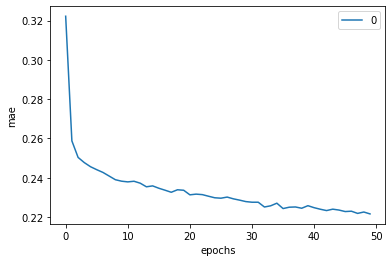

In [55]:
# Plot history (also known as a loss curve or a training curve)
pd.DataFrame(history.history['mae']).plot()
plt.ylabel("mae")
plt.xlabel("epochs")

In [56]:
## increasing number of hidden layers:
taxi_fare_model_2_b = tf.keras.Sequential([
                                       tf.keras.layers.Dense(32, activation='sigmoid', input_dim=X_train.shape[1]),
                                       tf.keras.layers.BatchNormalization(),
                                       tf.keras.layers.Dense(24, activation='sigmoid'),
                                       tf.keras.layers.BatchNormalization(),
                                       tf.keras.layers.Dense(16, activation='sigmoid'),
                                       tf.keras.layers.BatchNormalization(),
                                       tf.keras.layers.Dense(8, activation='sigmoid'),
                                       tf.keras.layers.BatchNormalization(),
                                       tf.keras.layers.Dense(1)                             ## final output layer with only 1 neuron
                                    ])


taxi_fare_model_2_b.compile(loss = tf.keras.losses.mae,
                        optimizer = tf.keras.optimizers.SGD(learning_rate=0.0095),
                        metrics = ["mape","mae","mse"]
                        )


history = taxi_fare_model_2_b.fit(X_train, y_train, epochs = 50,batch_size=128)


Epoch 1/50
603/603 [==============================] - 3s 2ms/step - loss: 0.3127 - mape: 200.1664 - mae: 0.3127 - mse: 0.3776
Epoch 2/50
603/603 [==============================] - 1s 2ms/step - loss: 0.2783 - mape: 188.7678 - mae: 0.2783 - mse: 0.3163
Epoch 3/50
603/603 [==============================] - 1s 2ms/step - loss: 0.2637 - mape: 185.2493 - mae: 0.2637 - mse: 0.2872
Epoch 4/50
603/603 [==============================] - 1s 2ms/step - loss: 0.2555 - mape: 180.3470 - mae: 0.2555 - mse: 0.2709
Epoch 5/50
603/603 [==============================] - 2s 3ms/step - loss: 0.2501 - mape: 178.1982 - mae: 0.2501 - mse: 0.2644
Epoch 6/50
603/603 [==============================] - 1s 2ms/step - loss: 0.2458 - mape: 175.0450 - mae: 0.2458 - mse: 0.2571
Epoch 7/50
603/603 [==============================] - 1s 2ms/step - loss: 0.2419 - mape: 172.5824 - mae: 0.2419 - mse: 0.2528
Epoch 8/50
603/603 [==============================] - 1s 2ms/step - loss: 0.2388 - mape: 169.2947 - mae: 0.2388 - mse:

In [57]:
taxi_fare_model_2_b.evaluate(X_test,y_test)

603/603 [==============================] - 1s 2ms/step - loss: 0.1868 - mape: 136.8685 - mae: 0.1868 - mse: 0.2041


[0.18680010735988617,
 136.8684844970703,
 0.18680010735988617,
 0.20408746600151062]

In [58]:
pred = taxi_fare_model_2_b.predict(X_test)
print("MAPE : ",mean_absolute_percentage_error(y_test,pred))
print("MAE : ",mean_absolute_error(y_test,pred))
print("MSE : ",mean_squared_error(y_test,pred))


603/603 [==============================] - 1s 1ms/step
MAPE :  1.3686844804818958
MAE :  0.18680017120553372
MSE :  0.20408747937600566


In [59]:
m2b=[mean_absolute_percentage_error(y_test,pred),mean_absolute_error(y_test,pred),mean_squared_error(y_test,pred)]
m2b

[1.3686844804818958, 0.18680017120553372, 0.20408747937600566]

Text(0.5, 0, 'epochs')

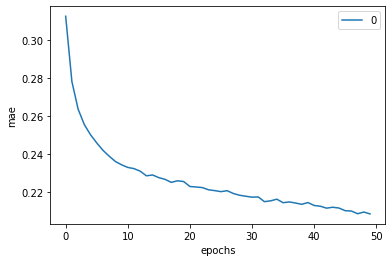

In [60]:
# Plot history (also known as a loss curve or a training curve)
pd.DataFrame(history.history['mae']).plot()
plt.ylabel("mae")
plt.xlabel("epochs")

**C. Experiment with activation functions**

**ReLU activation : max(x, 0)**

In [61]:
taxi_fare_model_3_relu = tf.keras.Sequential([
                                       tf.keras.layers.Dense(32, activation='relu', input_dim=X_train.shape[1]),
                                       tf.keras.layers.BatchNormalization(),
                                       tf.keras.layers.Dense(24, activation='relu'),
                                       tf.keras.layers.BatchNormalization(),
                                       tf.keras.layers.Dense(16, activation='relu'),
                                       tf.keras.layers.BatchNormalization(),
                                       tf.keras.layers.Dense(8, activation='relu'),
                                       tf.keras.layers.BatchNormalization(),
                                       tf.keras.layers.Dense(1)                             ## final output layer with only 1 neuron
                                    ])


taxi_fare_model_3_relu.compile(loss = tf.keras.losses.mae,
                        optimizer = tf.keras.optimizers.SGD(learning_rate=0.0095),
                        metrics = ["mape","mae","mse"]
                        )


history = taxi_fare_model_3_relu.fit(X_train, y_train, epochs = 50,batch_size=128)


Epoch 1/50
603/603 [==============================] - 2s 2ms/step - loss: 0.4416 - mape: 270.5710 - mae: 0.4416 - mse: 0.5477
Epoch 2/50
603/603 [==============================] - 1s 2ms/step - loss: 0.3001 - mape: 214.4231 - mae: 0.3001 - mse: 0.3074
Epoch 3/50
603/603 [==============================] - 1s 2ms/step - loss: 0.2692 - mape: 200.0704 - mae: 0.2692 - mse: 0.2793
Epoch 4/50
603/603 [==============================] - 1s 2ms/step - loss: 0.2581 - mape: 190.6752 - mae: 0.2581 - mse: 0.2700
Epoch 5/50
603/603 [==============================] - 1s 2ms/step - loss: 0.2498 - mape: 185.8052 - mae: 0.2498 - mse: 0.2642
Epoch 6/50
603/603 [==============================] - 1s 2ms/step - loss: 0.2451 - mape: 179.9362 - mae: 0.2451 - mse: 0.2592
Epoch 7/50
603/603 [==============================] - 2s 3ms/step - loss: 0.2409 - mape: 179.3396 - mae: 0.2409 - mse: 0.2526
Epoch 8/50
603/603 [==============================] - 1s 2ms/step - loss: 0.2379 - mape: 175.3175 - mae: 0.2379 - mse:

In [62]:
taxi_fare_model_3_relu.evaluate(X_test,y_test)

603/603 [==============================] - 1s 1ms/step - loss: 0.1883 - mape: 133.6286 - mae: 0.1883 - mse: 0.2160


[0.18834879994392395,
 133.6285858154297,
 0.18834879994392395,
 0.21600961685180664]

In [63]:
pred = taxi_fare_model_3_relu.predict(X_test)
print("MAPE : ",mean_absolute_percentage_error(y_test,pred))
print("MAE : ",mean_absolute_error(y_test,pred))
print("MSE : ",mean_squared_error(y_test,pred))

603/603 [==============================] - 1s 2ms/step
MAPE :  1.336286002731044
MAE :  0.18834890755151873
MSE :  0.2160095651354576


In [64]:
m3_relu=[mean_absolute_percentage_error(y_test,pred),mean_absolute_error(y_test,pred),mean_squared_error(y_test,pred)]
m3_relu

[1.336286002731044, 0.18834890755151873, 0.2160095651354576]

Text(0.5, 0, 'epochs')

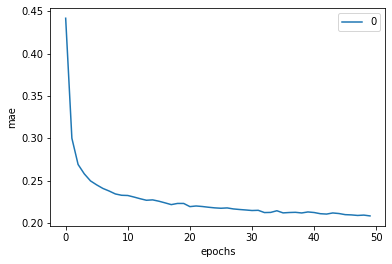

In [65]:
# Plot history (also known as a loss curve or a training curve)
pd.DataFrame(history.history['mae']).plot()
plt.ylabel("mae")
plt.xlabel("epochs")

**tanh activation : tanh(x) = sinh(x)/cosh(x) = ((exp(x) - exp(-x))/(exp(x) + exp(-x)))**

In [ ]:
taxi_fare_model_3_tanh = tf.keras.Sequential([
                                       tf.keras.layers.Dense(32, activation='tanh', input_dim=X_train.shape[1]),
                                       tf.keras.layers.BatchNormalization(),
                                       tf.keras.layers.Dense(24, activation='tanh'),
                                       tf.keras.layers.BatchNormalization(),
                                       tf.keras.layers.Dense(16, activation='tanh'),
                                       tf.keras.layers.BatchNormalization(),
                                       tf.keras.layers.Dense(8, activation='tanh'),
                                       tf.keras.layers.BatchNormalization(),
                                       tf.keras.layers.Dense(1)                             ## final output layer with only 1 neuron
                                    ])


taxi_fare_model_3_tanh.compile(loss = tf.keras.losses.mae,
                        optimizer = tf.keras.optimizers.SGD(learning_rate=0.0095),
                        metrics = ["mape","mae","mse"]
                        )


history = taxi_fare_model_3_tanh.fit(X_train, y_train, epochs = 50,batch_size=128)


Epoch 1/50
  1/603 [..............................] - ETA: 11:28 - loss: 1.2898 - mape: 547.4019 - mae: 1.2898 - mse: 2.9955

In [ ]:
taxi_fare_model_3_tanh.evaluate(X_test,y_test)

In [ ]:
pred = taxi_fare_model_3_tanh.predict(X_test)
print("MAPE : ",mean_absolute_percentage_error(y_test,pred))
print("MAE : ",mean_absolute_error(y_test,pred))
print("MSE : ",mean_squared_error(y_test,pred))

In [ ]:
m3_tanh=[mean_absolute_percentage_error(y_test,pred),mean_absolute_error(y_test,pred),mean_squared_error(y_test,pred)]
m3_tanh

In [ ]:
# Plot history (also known as a loss curve or a training curve)
pd.DataFrame(history.history['mae']).plot()
plt.ylabel("mae")
plt.xlabel("epochs")

**D.Experiment with regularization techniques:  Dropout rate, Early stopping**


**Dropout** : It randomly drops neurons from the neural network during training in each iteration which is equivalent to train different neural networks. The different networks will overfit in different ways, so the net effect of dropout will reduce overfitting.

In [ ]:

taxi_fare_model_4_a = tf.keras.Sequential([
                                       tf.keras.layers.Dense(32, activation='sigmoid', input_dim=X_train.shape[1]),  ## hidden layer 1
                                       tf.keras.layers.BatchNormalization(),
                                       Dropout(0.25), ## dropout 25% on hidden layer 1

                                       tf.keras.layers.Dense(24, activation='sigmoid'),   ## hidden layer 2
                                       tf.keras.layers.BatchNormalization(),
                                       Dropout(0.25), ## dropout 25% on hidden layer 2

                                       tf.keras.layers.Dense(16, activation='sigmoid'),   ## hidden layer 3
                                       tf.keras.layers.BatchNormalization(),
                                       Dropout(0.25), ## dropout 25% on hidden layer 3

                                       tf.keras.layers.Dense(8, activation='sigmoid'),    ## hidden layer 4
                                       tf.keras.layers.BatchNormalization(),
                                       Dropout(0.25), ## dropout 25% on hidden layer 4

                                       tf.keras.layers.Dense(1)                             ## final output layer with only 1 neuron
                                    ])


taxi_fare_model_4_a.compile(loss = tf.keras.losses.mae,
                        optimizer = tf.keras.optimizers.SGD(learning_rate=0.0095),
                        metrics = ["mape","mae","mse"]
                        )


history = taxi_fare_model_4_a.fit(X_train, y_train, epochs = 50,batch_size=128)

In [ ]:
taxi_fare_model_4_a.evaluate(X_test,y_test)

In [ ]:
pred = taxi_fare_model_4_a.predict(X_test)
print("MAPE : ",mean_absolute_percentage_error(y_test,pred))
print("MAE : ",mean_absolute_error(y_test,pred))
print("MSE : ",mean_squared_error(y_test,pred))

In [ ]:
m4_a=[mean_absolute_percentage_error(y_test,pred),mean_absolute_error(y_test,pred),mean_squared_error(y_test,pred)]
m4_a

In [ ]:
# Plot history (also known as a loss curve or a training curve)
pd.DataFrame(history.history['mae']).plot()
plt.ylabel("mae")
plt.xlabel("epochs")

**Early stopping** : After some iterations, test error starts to increase while the training error decreases. Hence the model is overfitting. So to combat this, we stop the model at the point when this starts to happen.

In [ ]:

taxi_fare_model_4_b = tf.keras.Sequential([
                                       tf.keras.layers.Dense(32, activation='sigmoid', input_dim=X_train.shape[1]),
                                       tf.keras.layers.BatchNormalization(),
                                       tf.keras.layers.Dense(24, activation='sigmoid'),
                                       tf.keras.layers.BatchNormalization(),
                                       tf.keras.layers.Dense(16, activation='sigmoid'),
                                       tf.keras.layers.BatchNormalization(),
                                       tf.keras.layers.Dense(8, activation='sigmoid'),
                                       tf.keras.layers.BatchNormalization(),
                                       tf.keras.layers.Dense(1)                             ## final output layer with only 1 neuron
                                    ])


taxi_fare_model_4_b.compile(loss = tf.keras.losses.mae,
                        optimizer = tf.keras.optimizers.SGD(learning_rate=0.0095),
                        metrics = ["mape","mae","mse"]
                        )


callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_mae', patience=3)]
history = taxi_fare_model_4_b.fit(X_train, y_train, epochs = 50, batch_size=128, validation_split=0.2, callbacks=callbacks )

In [ ]:
taxi_fare_model_4_b.evaluate(X_test,y_test)

In [ ]:
pred = taxi_fare_model_4_b.predict(X_test)
print("MAPE : ",mean_absolute_percentage_error(y_test,pred))
print("MAE : ",mean_absolute_error(y_test,pred))
print("MSE : ",mean_squared_error(y_test,pred))

In [ ]:
m4_b=[mean_absolute_percentage_error(y_test,pred),mean_absolute_error(y_test,pred),mean_squared_error(y_test,pred)]
m4_b

In [ ]:
# Plot history (also known as a loss curve or a training curve)

pd.DataFrame(history.history['val_mae']).plot()
plt.title('validation mae')
plt.ylabel("val_mae")
plt.xlabel("epochs")


Using both dropout and early stopping simultaneously

In [ ]:

taxi_fare_model_4_c = tf.keras.Sequential([
                                       tf.keras.layers.Dense(32, activation='sigmoid', input_dim=X_train.shape[1]),  ## hidden layer 1
                                       tf.keras.layers.BatchNormalization(),
                                       Dropout(0.25), ## dropout 25% on hidden layer 1

                                       tf.keras.layers.Dense(24, activation='sigmoid'),   ## hidden layer 2
                                       tf.keras.layers.BatchNormalization(),
                                       Dropout(0.25), ## dropout 25% on hidden layer 2

                                       tf.keras.layers.Dense(16, activation='sigmoid'),   ## hidden layer 3
                                       tf.keras.layers.BatchNormalization(),
                                       Dropout(0.25), ## dropout 25% on hidden layer 3

                                       tf.keras.layers.Dense(8, activation='sigmoid'),    ## hidden layer 4
                                       tf.keras.layers.BatchNormalization(),
                                       Dropout(0.25), ## dropout 25% on hidden layer 4

                                       tf.keras.layers.Dense(1)                             ## final output layer with only 1 neuron
                                    ])

taxi_fare_model_4_c.compile(loss = tf.keras.losses.mae,
                        optimizer = tf.keras.optimizers.Adam(learning_rate=0.0095),
                        metrics = ["mape","mae","mse"]
                        )

callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_mae', patience=3)]
history = taxi_fare_model_4_c.fit(X_train, y_train, epochs = 50,batch_size=128,validation_split=0.2,callbacks=callbacks)

In [ ]:
taxi_fare_model_4_c.evaluate(X_test,y_test)

In [ ]:
pred = taxi_fare_model_4_c.predict(X_test)
print("MAPE : ",mean_absolute_percentage_error(y_test,pred))
print("MAE : ",mean_absolute_error(y_test,pred))
print("MSE : ",mean_squared_error(y_test,pred))

In [ ]:
m4_c=[mean_absolute_percentage_error(y_test,pred),mean_absolute_error(y_test,pred),mean_squared_error(y_test,pred)]
m4_c

In [ ]:
# Plot history (also known as a loss curve or a training curve)

pd.DataFrame(history.history['val_mae']).plot()
plt.title('validation mae')
plt.ylabel("val_mae")
plt.xlabel("epochs")


In [ ]:
pd.DataFrame(history.history['mae']).plot()
plt.title(' mae')
plt.ylabel("mae")
plt.xlabel("epochs")


**E.Experiment with at least 2 more Optimizers**

In [ ]:
## using RMSprop as optimizer

# 1. Create a model
taxi_fare_model_5_a = tf.keras.Sequential([
                                       tf.keras.layers.Dense(32, activation='sigmoid', input_dim=X_train.shape[1]),
                                       tf.keras.layers.BatchNormalization(),
                                       tf.keras.layers.Dense(24, activation='sigmoid'),
                                       tf.keras.layers.BatchNormalization(),
                                       tf.keras.layers.Dense(16, activation='sigmoid'),
                                       tf.keras.layers.BatchNormalization(),
                                       tf.keras.layers.Dense(8, activation='sigmoid'),
                                       tf.keras.layers.BatchNormalization(),
                                       tf.keras.layers.Dense(1)                             ## final output layer with only 1 neuron
                                    ])

# 2. Compile the model
taxi_fare_model_5_a.compile(loss = tf.keras.losses.mae,
                        optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.0095),
                        metrics = ["mape","mae","mse"]
                        )

# 3. Fitting the model
history = taxi_fare_model_5_a.fit(X_train, y_train, epochs = 50,batch_size=128)

In [ ]:
taxi_fare_model_5_a.evaluate(X_test,y_test)

In [ ]:
pred = taxi_fare_model_5_a.predict(X_test)
print("MAPE : ",mean_absolute_percentage_error(y_test,pred))
print("MAE : ",mean_absolute_error(y_test,pred))
print("MSE : ",mean_squared_error(y_test,pred))

In [ ]:
m5_a=[mean_absolute_percentage_error(y_test,pred),mean_absolute_error(y_test,pred),mean_squared_error(y_test,pred)]
m5_a

In [ ]:
# Plot history (also known as a loss curve or a training curve)

pd.DataFrame(history.history['mae']).plot()
plt.ylabel("mae")
plt.xlabel("epochs")

In [ ]:
## using Adamax as optimizer

# 1. Create a model
taxi_fare_model_5_b = tf.keras.Sequential([
                                       tf.keras.layers.Dense(32, activation='sigmoid', input_dim=X_train.shape[1]),
                                       tf.keras.layers.BatchNormalization(),
                                       tf.keras.layers.Dense(24, activation='sigmoid'),
                                       tf.keras.layers.BatchNormalization(),
                                       tf.keras.layers.Dense(16, activation='sigmoid'),
                                       tf.keras.layers.BatchNormalization(),
                                       tf.keras.layers.Dense(8, activation='sigmoid'),
                                       tf.keras.layers.BatchNormalization(),
                                       tf.keras.layers.Dense(1)                             ## final output layer with only 1 neuron
                                    ])

# 2. Compile the model
taxi_fare_model_5_b.compile(loss = tf.keras.losses.mae,
                        optimizer = tf.keras.optimizers.Adamax(learning_rate=0.0095),
                        metrics = ['mape','mae','mse']
                        )

# 3. Fitting the model
history = taxi_fare_model_5_b.fit(X_train, y_train, epochs = 50,batch_size=128)

In [ ]:
taxi_fare_model_5_b.evaluate(X_test,y_test)

In [ ]:
pred = taxi_fare_model_5_b.predict(X_test)
print("MAPE : ",mean_absolute_percentage_error(y_test,pred))
print("MAE : ",mean_absolute_error(y_test,pred))
print("MSE : ",mean_squared_error(y_test,pred))

In [ ]:
m5_b=[mean_absolute_percentage_error(y_test,pred),mean_absolute_error(y_test,pred),mean_squared_error(y_test,pred)]
m5_b

In [ ]:
# Plot history (also known as a loss curve or a training curve)

pd.DataFrame(history.history['mae']).plot()
plt.ylabel("mae")
plt.xlabel("epochs")

Performance metrices(MAPE, MAE, MSE) from each of the models:

In [ ]:
Performance_metrics=pd.DataFrame(
                                 {"Basic Neural Network": m1,
                                  "Decreasing layers & neurons":m2a,
                                  "Increasing layers & neurons":m2b,
                                  "ReLU activation":m3_relu,
                                  "tanh activation":m3_tanh,
                                  "Dropout ":m4_a,
                                  "Early Stopping ":m4_b,
                                  "Dropout + Early stopping":m4_c,
                                  "RmsProp optimizer":m5_a,
                                  "Adamax":m5_b},
                                 index=["MAPE",'MAE','MSE'])

In [ ]:
Performance_metrics

In [ ]:
import scipy.stats as st
mape_arr=np.array(Performance_metrics.loc['MAPE'].tolist())
mae_arr=np.array(Performance_metrics.loc['MAE'].tolist())
mse_arr=np.array(Performance_metrics.loc['MSE'].tolist())

# create 95% confidence interval
def confidence(arr):
  c=st.t.interval(alpha=0.95, df=len(arr)-1,loc=np.mean(arr),scale=st.sem(arr))
  return c



In [ ]:
c_mape=confidence(mape_arr)
c_mae=confidence(mae_arr)
c_mse=confidence(mse_arr)

In [ ]:
confidence_table = pd.DataFrame({"Minimum":[c_mape[0],c_mae[0],c_mse[0]],
                                 "Maximum":[c_mape[1],c_mae[1],c_mse[1]]},
                                index=["MAPE",'MAE','MSE'])

In [ ]:
confidence_table

Neural network having 4 hidden layers and using Adamax optimizer is giving me the least error among all methods so now i will predict the fare amount usig my that model (model 5_b)

In [ ]:
predicted_fare = taxi_fare_model_5_b.predict(test_scaled)

In [ ]:
predicted_fare

In [ ]:
upper_y = round(train.fare_amount.mean() + (3*train.fare_amount.std()))
upper_y

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(min(train['fare_amount']), upper_y))

predicted = scaler.fit_transform(predicted_fare)

predicted

In [ ]:
test['fare_predicted']=predicted

In [ ]:
test.head()

In [ ]:
result = test.drop(['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'passenger_count', 'Year','Month','Date','Day of Week','Hour','H_Distance'],axis=1)
result